# Concordance Analysis: SPECT/CT + Sestamibi Negative, 4D CT Positive

### Objective

Evaluate **4D CT concordance with surgical findings** in patients with **non-localizing SPECT/CT and/or Sestamibi but positive 4D CT scans**.

### Data Source

- `side_concordance_results.xlsx` (pre-operative imaging and surgical outcomes)

### Outputs

- **Total cases:** 50
- **Exact match:** 24 (**48.0%**)
- **Side-only match:** 9 (**18.0%**)
- **Combined side match:** 33 (**66.0%**)
- **Incorrect localization:** 17 (**34.0%**)
---

In [1]:
import pandas as pd 
preop_imaging_df = pd.read_excel('../../Data/side_concordance_results.xlsx')

In [2]:
def extract_side(location):
    if pd.isnull(location):
        return 'No Scan'
    
    if 'Left' in location:
        return 'Left'
    elif 'Right' in location:
        return 'Right'
    else:
        return 'Unknown'

In [3]:
def check_concordance(row):
    imaging = row['4D CT Scan']
    surgical = row['Surgical_Findings']
    
    if pd.isnull(imaging) or pd.isnull(surgical):
        return 'Unknown'
    imaging_glands = [g.strip() for g in imaging.split(',')]
    surgical_glands = [g.strip() for g in surgical.split(',')]
    
    if any(sg in imaging_glands for sg in surgical_glands):
        return 'Yes (Exact)'
    
    imaging_sides = []
    for ig in imaging_glands:
        if 'Left' in ig:
            imaging_sides.append('Left')
        if 'Right' in ig:
            imaging_sides.append('Right')
    
    surgical_sides = []
    for sg in surgical_glands:
        if 'Left' in sg:
            surgical_sides.append('Left')
        if 'Right' in sg:
            surgical_sides.append('Right')
    
    if any(side in surgical_sides for side in imaging_sides):
        return 'Yes (Side)'
    
    return 'Incorrect Localization'


In [4]:
def check_spect_sestamibi(row):
    spect = row['SPECT/CT']
    sestamibi = row['Sestamibi']
    
    spect_localizing = pd.notnull(spect) and spect not in ['No Scan', 'Non-localizing']
    sestamibi_localizing = pd.notnull(sestamibi) and sestamibi not in ['No Scan', 'Non-localizing']
    
    if not pd.notnull(spect) and not pd.notnull(sestamibi):
        return 'No SPECT/CT or Sestamibi Recorded'
    elif spect_localizing and sestamibi_localizing:
        return f"SPECT: {spect} | Sestamibi: {sestamibi}"
    elif spect_localizing:
        return f'SPECT/CT: {spect}'
    elif sestamibi_localizing:
        return f'Sestamibi: {sestamibi}'
    else:
        return 'Non-localizing'

In [5]:
preop_imaging_df['SPECT/CT-Sestamibi'] = preop_imaging_df.apply(check_spect_sestamibi, axis=1)
preop_imaging_df['SPECT/CT-Sestamibi'].head()

0    Sestamibi: Right Inferior
1               Non-localizing
2     Sestamibi: Left Inferior
3     Sestamibi: Left Inferior
4              Sestamibi: Left
Name: SPECT/CT-Sestamibi, dtype: object

In [6]:
preop_imaging_df

,Procedure_Date,Patient_ID,Age,Gender,Surgical_Findings,Surgical Cure,SPECT/CT,Ultrasound,4D CT Scan,Sestamibi,MRI,Ultrasound_Concordance,SPECT/CT_Concordance,4D CT Scan_Concordance,Sestamibi_Concordance,MRI_Concordance,SPECT/CT-Sestamibi
0,2012-04-24,156895,77,F,Right Inferior,Yes,NaN,NaN,NaN,Right Inferior,Right Inferior,No Scan,No Scan,No Scan,Yes (Exact),Yes (Exact),Sestamibi: Right Inferior
1,2012-05-08,182059,70,F,Left Inferior,Yes,NaN,Non-localizing,NaN,Non-localizing,Right Inferior,No,No Scan,No Scan,No,No,Non-localizing
2,2012-05-22,150593,65,F,Left Inferior,Yes,NaN,Left Inferior,NaN,Left Inferior,NaN,Yes (Exact),No Scan,No Scan,Yes (Exact),No Scan,Sestamibi: Left Inferior
3,2012-07-03,183346,69,F,"Left Superior, Right Superior",Yes,NaN,NaN,NaN,Left Inferior,Non-localizing,No Scan,No Scan,No Scan,Yes (Side),No,Sestamibi: Left Inferior
4,2012-07-18,183255,74,F,Left Superior,Yes,NaN,Left,NaN,Left,NaN,Yes (Side),No Scan,No Scan,Yes (Side),No Scan,Sestamibi: Left
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,2025-04-29,310063,48,M,"Left Superior, Right Superior",Yes,"Left, Right","Left Inferior, Right Inferior",NaN,NaN,NaN,Yes (Side),Yes (Side),No Scan,No Scan,No Scan,"SPECT/CT: Left, Right"
401,2025-04-29,311569,47,F,Right Inferior,Yes,Right Inferior,NaN,Right Inferior,NaN,NaN,No Scan,Yes (Exact),Yes (Exact),No Scan,No Scan,SPECT/CT: Right Inferior
402,2025-05-06,309738,73,F,Right Inferior,Yes,Right Inferior,Non-localizing,"Left Superior, Right Inferior",NaN,NaN,No,Yes (Exact),No,No Scan,No Scan,SPECT/CT: Right Inferior
403,2025-05-13,194173,73,F,"Left Inferior, Right Superior, Right Inferior",Yes,Right Superior,Non-localizing,Right,NaN,NaN,No,No,No,No Scan,No Scan,SPECT/CT: Right Superior


In [7]:
modality_spectmibi = 'SPECT/CT-Sestamibi'
modality_4dct = '4D CT Scan'

preop_imaging_df['4D CT Imaging Side'] = preop_imaging_df[modality_4dct].apply(extract_side)
preop_imaging_df['Surgical Side'] = preop_imaging_df['Surgical_Findings'].apply(extract_side)

negative_spectmibi = preop_imaging_df[preop_imaging_df[modality_spectmibi] == 'Non-localizing']

spectmibi_neg_4d_pos = negative_spectmibi[negative_spectmibi['4D CT Imaging Side'].isin(['Left', 'Right'])]



In [8]:
spectmibi_neg_4d_pos = spectmibi_neg_4d_pos.copy()
spectmibi_neg_4d_pos['Calculated Concordance'] = spectmibi_neg_4d_pos.apply(check_concordance, axis=1)

total_cases = spectmibi_neg_4d_pos.shape[0]
total_cases


50

In [9]:
exact_count = spectmibi_neg_4d_pos[spectmibi_neg_4d_pos['Calculated Concordance'] == 'Yes (Exact)'].shape[0]
side_count = spectmibi_neg_4d_pos[spectmibi_neg_4d_pos['Calculated Concordance'] == 'Yes (Side)'].shape[0]
incorrect_count = spectmibi_neg_4d_pos[spectmibi_neg_4d_pos['Calculated Concordance'] == 'Incorrect Localization'].shape[0]
print(f'Exact Count: {exact_count}')
print(f'Side Count: {side_count}')
print(f'Incorrect Count: {incorrect_count}')

Exact Count: 24
Side Count: 9
Incorrect Count: 17


In [10]:
exact_pct = round((exact_count / total_cases) * 100, 2) if total_cases > 0 else None 
side_pct = round((side_count / total_cases) * 100, 2) if total_cases > 0 else None
incorrect_pct = round((incorrect_count / total_cases) * 100, 2) if total_cases > 0 else None 
print(f'Exact Percentage: {exact_pct}')
print(f'Side Percentage: {side_pct}')
print(f'Incorrect Percentage: {incorrect_pct}')

Exact Percentage: 48.0
Side Percentage: 18.0
Incorrect Percentage: 34.0


In [11]:
total_side_match_count = side_count + exact_count
total_side_match_pct = (total_side_match_count / total_cases) * 100 if total_cases > 0 else None

spectmibi_neg_4d_pos_summary_df = pd.DataFrame({
    'Match Type': [
        'Exact Match',
        'Total Side Match (Exact + Side-only)',
        'Incorect Localization'
    ],
    'Count': [
        exact_count,
        total_side_match_count,
        incorrect_count
    ],
    'Percentage': [
        f"{exact_pct:.2f}%" if exact_pct is not None else 'N/A',
        f"{total_side_match_pct:.2f}%" if total_side_match_pct is not None else 'N/A',
        f"{incorrect_pct:.2f}%" if incorrect_pct is not None else 'N/A'

    ]
     
})
print(f"Total SPECT/CT + Sestamibi negative / 4D CT positive cases: {total_cases}")
display(spectmibi_neg_4d_pos_summary_df)

Total SPECT/CT + Sestamibi negative / 4D CT positive cases: 50


,Match Type,Count,Percentage
0,Exact Match,24,48.00%
1,Total Side Match (Exact + Side-only),33,66.00%
2,Incorect Localization,17,34.00%


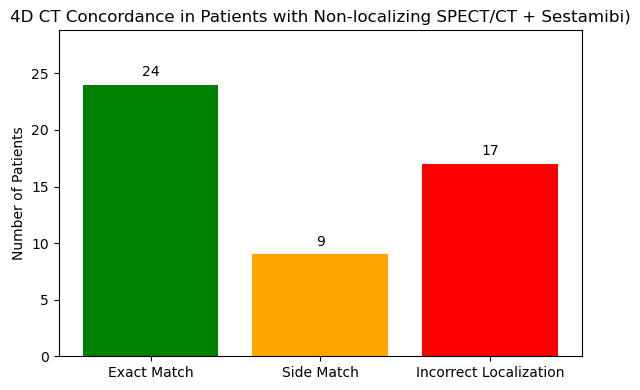

In [23]:
import matplotlib.pyplot as plt 
labels = ['Exact Match', 'Side Match', 'Incorrect Localization']
counts = [exact_count, side_count, incorrect_count]
colors = ['green', 'orange', 'red']

plt.figure(figsize=(6,4))
bars = plt.bar(labels, counts, color=colors)

for bar in bars: 
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, f'{int(height)}',
             ha='center', va='bottom', fontsize=10)
    
plt.title('4D CT Concordance in Patients with Non-localizing SPECT/CT + Sestamibi)', fontsize=12)
plt.ylabel('Number of Patients')
plt.ylim(0, max(counts)*1.2)  # Adds headroom for labels

plt.tight_layout()
plt.show()


---

### Interpretation

4D CT provided **localization (exact or side)** in **two-thirds of patients** with non-localizing SPECT/CT + Sestamibi scans, supporting its role as a **salvage imaging modality** in challenging cases.



### Next Steps

- Compare to overall **4D CT sensitivity and PPV** to guide imaging algorithm recommendations for the manuscript.